# Анализ моделей машинного обучения

## Модели:
1. Random Forest
2. SVM с линейным ядром
3. KNN
4. Логистическая регрессия

## Метрики сравнения:
- Accuracy
- Precision
- Recall
- F1-мера
- ROC-AUC
- Важность признаков

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


## 1. Загрузка и подготовка данных

In [35]:
df = pd.read_csv("norm_dataframe.csv", index_col=0)
print(f"Загружено {len(df)} строк, {len(df.columns)} признаков")

target = "RESULT"
print(f"\nРаспределение классов:")
print(df[target].value_counts(normalize=True).values)

Загружено 95367 строк, 31 признаков

Распределение классов:
[0.50073925 0.49926075]


In [33]:
drop_cols = ["match_idx", "tourney_date", "PLAYER_1", "PLAYER_2"]
drop_cols = [col for col in drop_cols if col in df.columns]

df_clean = df.drop(columns=drop_cols)

X = df_clean.drop(columns=[target])
y = df_clean[target]

print(f"Размерность признаков X: {X.shape}")
print(f"Признаки: {list(X.columns)}")

Размерность признаков X: (95367, 26)
Признаки: ['ATP_POINT_DIFF', 'ATP_RANK_DIFF', 'AGE_DIFF', 'HEIGHT_DIFF', 'BEST_OF', 'DRAW_SIZE', 'H2H_DIFF', 'H2H_SURFACE_DIFF', 'DIFF_N_GAMES', 'ELO_DIFF', 'ELO_SURFACE_DIFF', 'ELO_GRAD_5_DIFF', 'ELO_GRAD_10_DIFF', 'ELO_GRAD_20_DIFF', 'ELO_GRAD_35_DIFF', 'ELO_GRAD_50_DIFF', 'ELO_GRAD_100_DIFF', 'ELO_GRAD_250_DIFF', 'P_1STIN_LAST_2000_DIFF', 'P_1STWON_LAST_2000_DIFF', 'P_2NDWON_LAST_2000_DIFF', 'P_ACE_LAST_2000_DIFF', 'P_BPSAVED_LAST_2000_DIFF', 'P_DF_LAST_2000_DIFF', 'P_SVGMS_LAST_2000_DIFF', 'P_WIN_LAST_2000_DIFF']


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train размер: {X_train.shape[0]} ({X_train.shape[0] / len(X) * 100:.1f}%)")
print(f"Test размер: {X_test.shape[0]} ({X_test.shape[0] / len(X) * 100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train размер: 76293 (80.0%)
Test размер: 19074 (20.0%)


## 2. Обучение моделей

In [12]:
results = {}
models = {}
predictions = {}

In [13]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    min_samples_leaf=30,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

models['Random Forest'] = rf
predictions['Random Forest'] = {
    'y_pred': rf.predict(X_test),
    'y_proba': rf.predict_proba(X_test)[:, 1],
    'X_test': X_test
}

print("Random Forest обучен!")

Random Forest обучен!


In [14]:

svm_linear = SVC(
    kernel='linear',
    C=1.0,
    probability=True,
    random_state=42
)
svm_linear.fit(X_train_scaled, y_train)

models['SVM (Linear)'] = svm_linear
predictions['SVM (Linear)'] = {
    'y_pred': svm_linear.predict(X_test_scaled),
    'y_proba': svm_linear.predict_proba(X_test_scaled)[:, 1],
    'X_test': X_test_scaled
}

print("SVM (Linear) обучен!")

SVM (Linear) обучен!


In [31]:
knn = KNeighborsClassifier(n_neighbors=49)
knn.fit(X_train_scaled, y_train)

models['KNN'] = knn
predictions['KNN'] = {
    'y_pred': knn.predict(X_test_scaled),
    'y_proba': knn.predict_proba(X_test_scaled)[:, 1],
    'X_test': X_test_scaled
}

print(f"KNN обучен!")

KNN обучен!


In [16]:


logreg = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train_scaled, y_train)

models['Logistic Regression'] = logreg
predictions['Logistic Regression'] = {
    'y_pred': logreg.predict(X_test_scaled),
    'y_proba': logreg.predict_proba(X_test_scaled)[:, 1],
    'X_test': X_test_scaled
}

print("Логистическая регрессия обучена!")

Логистическая регрессия обучена!


## 3. Расчет метрик качества

In [36]:
metrics_data = []

for model_name, pred_data in predictions.items():
    y_pred = pred_data['y_pred']
    y_proba = pred_data['y_proba']
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    metrics_data.append(metrics)

results_df = pd.DataFrame(metrics_data)
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)


print("Сравнительная таблица метрик\n")

print(results_df.to_string(index=False))

Сравнительная таблица метрик

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.668030   0.669500 0.661766  0.665610 0.732260
       SVM (Linear)  0.667506   0.669148 0.660716  0.664905 0.731864
      Random Forest  0.666090   0.666702 0.662291  0.664489 0.731682
                KNN  0.653193   0.654846 0.645700  0.650241 0.713651


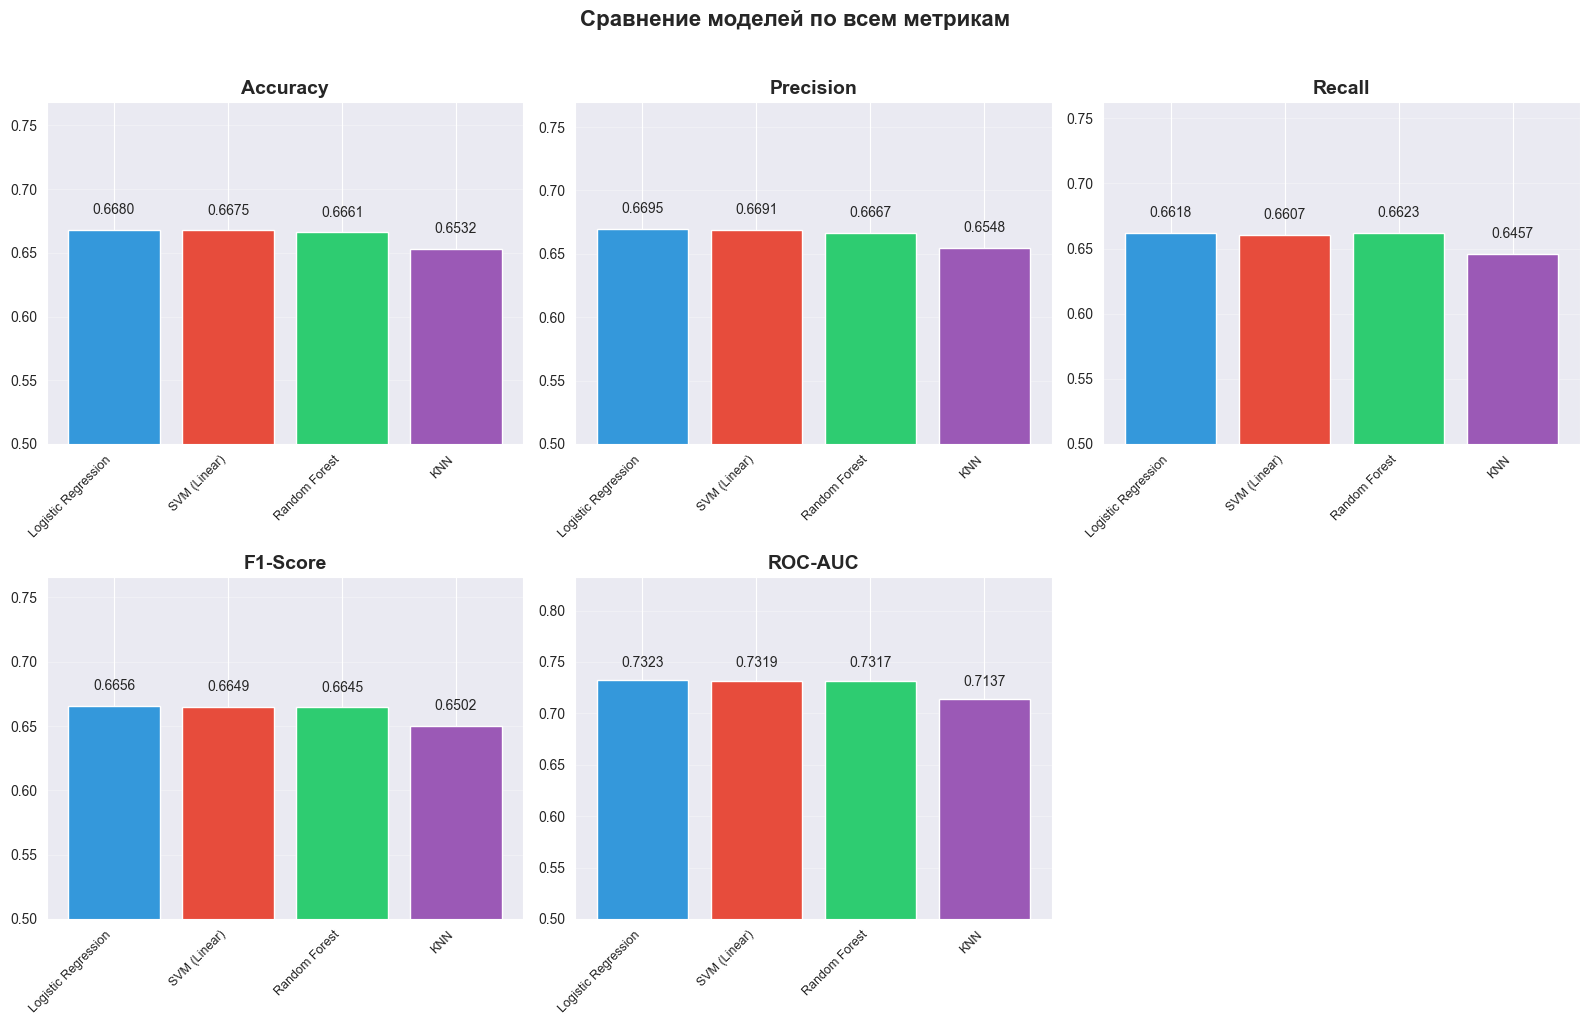

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    values = results_df[metric].values
    model_names = results_df['Model'].values
    
    bars = ax.bar(model_names, values, color=colors)
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylim(0.5, max(values) + 0.1)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    ax.grid(alpha=0.3, axis='y')
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., val + 0.01, 
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)

axes[1, 2].axis('off')

plt.suptitle('Сравнение моделей по всем метрикам', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. ROC-кривые

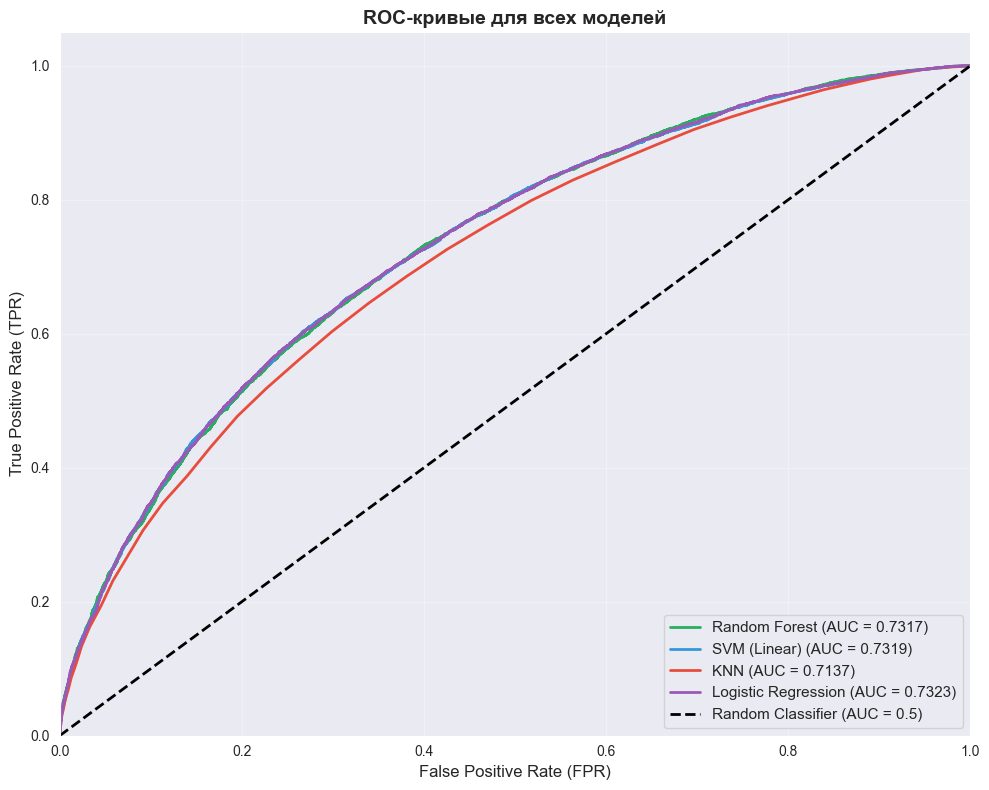

In [20]:
plt.figure(figsize=(10, 8))

colors = ['#27ae60', '#3498db', '#e74c3c', '#9b59b6']

for (model_name, pred_data), color in zip(predictions.items(), colors):
    y_proba = pred_data['y_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривые для всех моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Матрицы ошибок

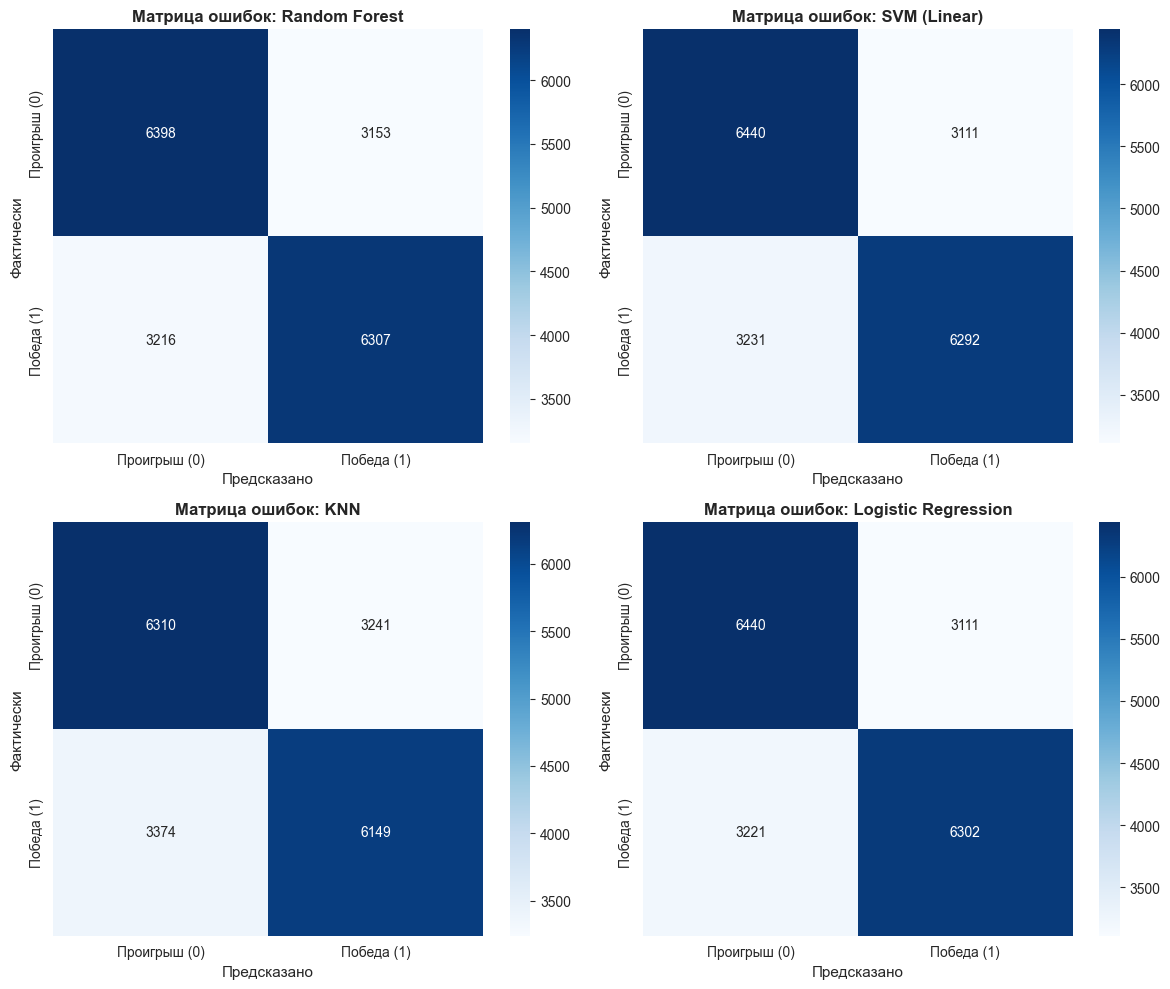

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (model_name, pred_data) in zip(axes.flatten(), predictions.items()):
    y_pred = pred_data['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Проигрыш (0)', 'Победа (1)'],
                yticklabels=['Проигрыш (0)', 'Победа (1)'])
    ax.set_xlabel('Предсказано', fontsize=11)
    ax.set_ylabel('Фактически', fontsize=11)
    ax.set_title(f'Матрица ошибок: {model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Важность признаков

ВАЖНОСТЬ ПРИЗНАКОВ - RANDOM FOREST

Топ-15 важных признаков (Random Forest):
                 Feature  Importance
                ELO_DIFF    0.168707
        ELO_SURFACE_DIFF    0.165191
          ATP_POINT_DIFF    0.111268
           ATP_RANK_DIFF    0.103687
    P_WIN_LAST_2000_DIFF    0.072734
            DIFF_N_GAMES    0.041495
                AGE_DIFF    0.034395
P_BPSAVED_LAST_2000_DIFF    0.033693
 P_1STWON_LAST_2000_DIFF    0.023409
    P_ACE_LAST_2000_DIFF    0.022908
     P_DF_LAST_2000_DIFF    0.022223
         ELO_GRAD_5_DIFF    0.021894
  P_SVGMS_LAST_2000_DIFF    0.021115
 P_2NDWON_LAST_2000_DIFF    0.020891
        ELO_GRAD_10_DIFF    0.020796


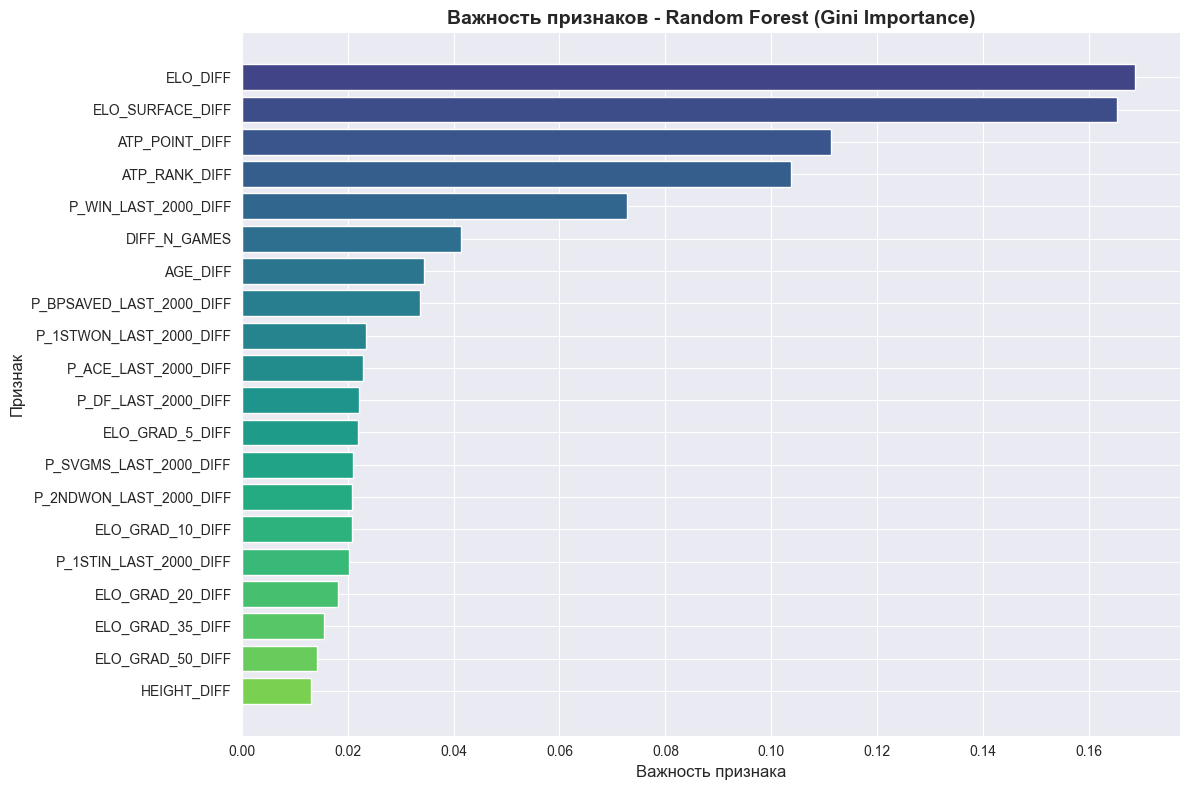

In [22]:
print("="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - RANDOM FOREST")
print("="*60)

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nТоп-15 важных признаков (Random Forest):")
print(rf_importance.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_rf = rf_importance.head(20)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_rf)))
plt.barh(top_rf['Feature'], top_rf['Importance'], color=colors)
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ВАЖНОСТЬ ПРИЗНАКОВ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (коэффициенты)

Топ-15 важных признаков (Логистическая регрессия):
                 Feature  Coefficient
        ELO_SURFACE_DIFF     0.430796
                ELO_DIFF     0.366505
           ATP_RANK_DIFF     0.232932
                AGE_DIFF    -0.209930
 P_1STWON_LAST_2000_DIFF     0.108784
          ATP_POINT_DIFF     0.087083
            DIFF_N_GAMES     0.067304
  P_1STIN_LAST_2000_DIFF    -0.048239
        ELO_GRAD_50_DIFF    -0.044527
    P_WIN_LAST_2000_DIFF    -0.043415
P_BPSAVED_LAST_2000_DIFF    -0.039810
       ELO_GRAD_100_DIFF    -0.036918
                H2H_DIFF     0.036832
     P_DF_LAST_2000_DIFF    -0.027831
         ELO_GRAD_5_DIFF     0.025535


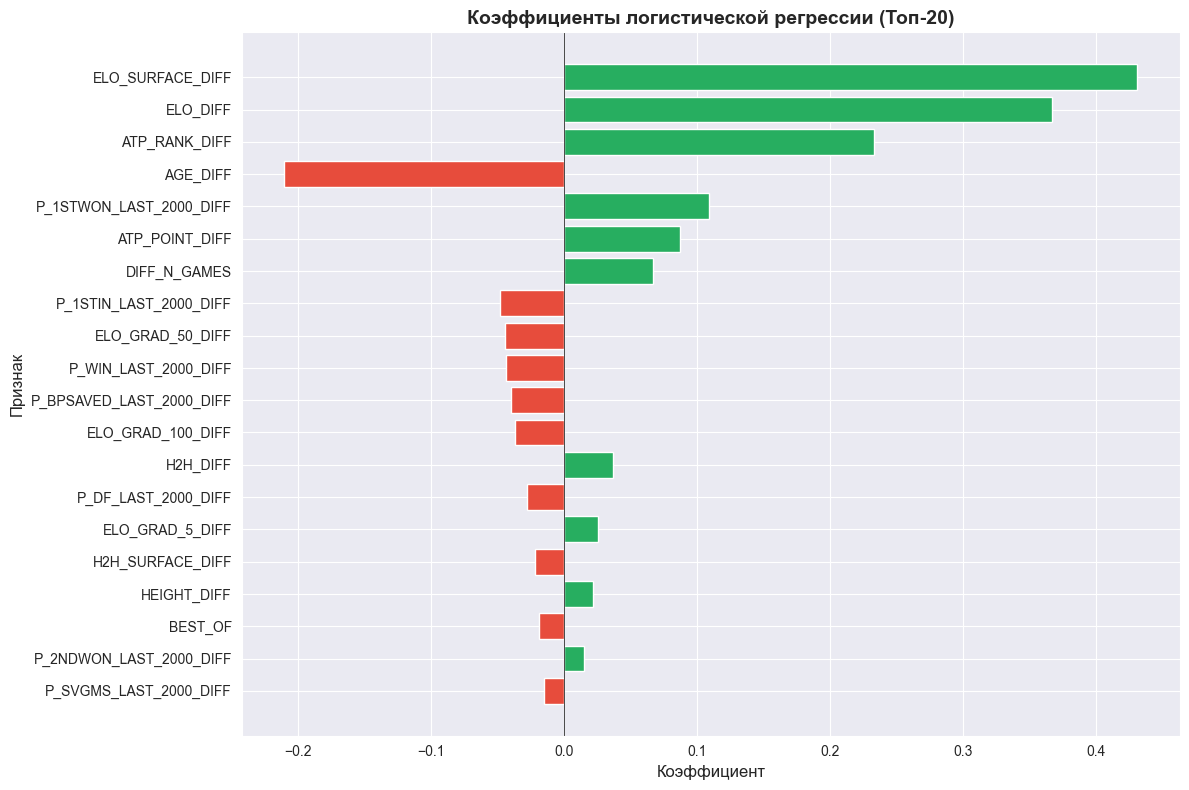

In [23]:
print("="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (коэффициенты)")
print("="*60)

logreg_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': models['Logistic Regression'].coef_[0],
    'Abs_Coefficient': np.abs(models['Logistic Regression'].coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nТоп-15 важных признаков (Логистическая регрессия):")
print(logreg_importance[['Feature', 'Coefficient']].head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_logreg = logreg_importance.head(20)
colors = ['#27ae60' if c > 0 else '#e74c3c' for c in top_logreg['Coefficient']]
plt.barh(top_logreg['Feature'], top_logreg['Coefficient'], color=colors)
plt.xlabel('Коэффициент', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Коэффициенты логистической регрессии (Топ-20)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ВАЖНОСТЬ ПРИЗНАКОВ - SVM (LINEAR) (коэффициенты)

Топ-15 важных признаков (SVM Linear):
                 Feature  Coefficient
                ELO_DIFF     0.461030
        ELO_SURFACE_DIFF     0.420847
           ATP_RANK_DIFF     0.279775
                AGE_DIFF    -0.238335
 P_1STWON_LAST_2000_DIFF     0.190493
  P_1STIN_LAST_2000_DIFF    -0.099801
            DIFF_N_GAMES     0.081310
          ATP_POINT_DIFF    -0.056094
                H2H_DIFF     0.049951
        ELO_GRAD_50_DIFF    -0.048473
P_BPSAVED_LAST_2000_DIFF    -0.042595
    P_ACE_LAST_2000_DIFF    -0.038192
         ELO_GRAD_5_DIFF     0.031566
     P_DF_LAST_2000_DIFF    -0.031064
       ELO_GRAD_100_DIFF    -0.030520


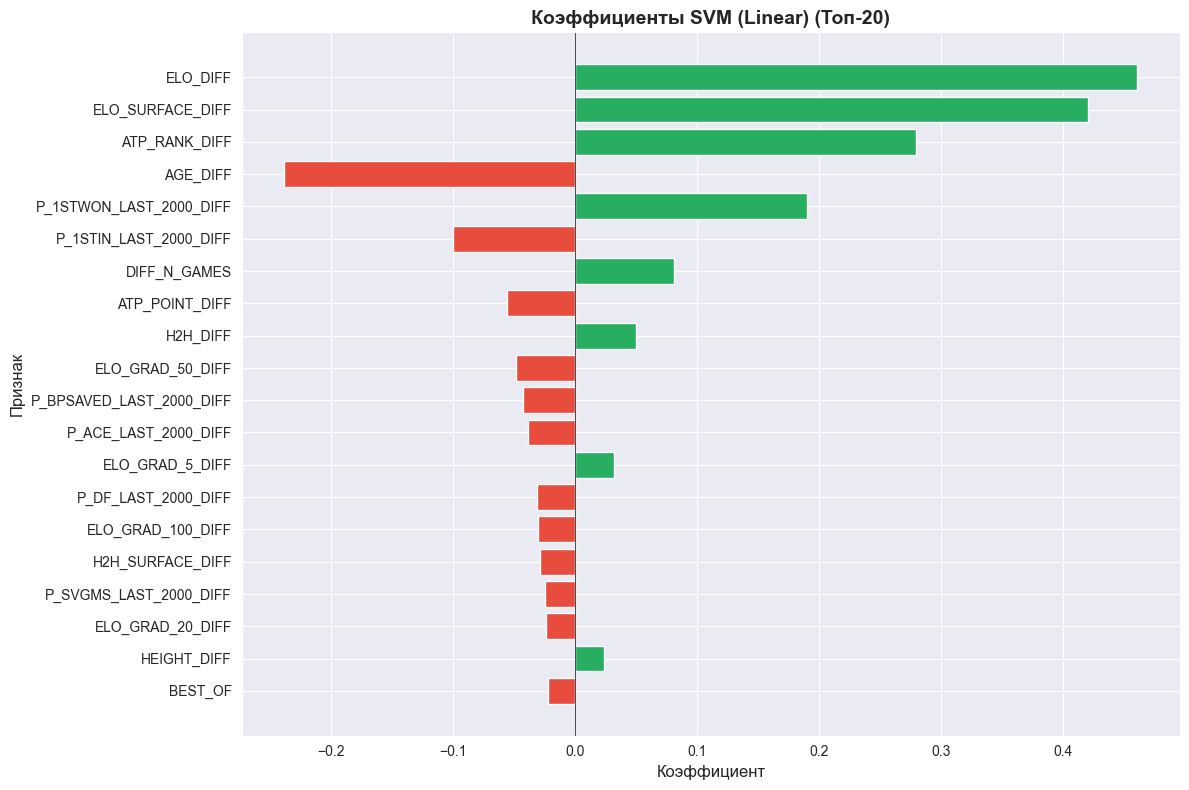

In [24]:
print("="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - SVM (LINEAR) (коэффициенты)")
print("="*60)

svm_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': models['SVM (Linear)'].coef_[0],
    'Abs_Coefficient': np.abs(models['SVM (Linear)'].coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nТоп-15 важных признаков (SVM Linear):")
print(svm_importance[['Feature', 'Coefficient']].head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_svm = svm_importance.head(20)
colors = ['#27ae60' if c > 0 else '#e74c3c' for c in top_svm['Coefficient']]
plt.barh(top_svm['Feature'], top_svm['Coefficient'], color=colors)
plt.xlabel('Коэффициент', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Коэффициенты SVM (Linear) (Топ-20)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

ВАЖНОСТЬ ПРИЗНАКОВ - KNN (Permutation Importance)

Топ-15 важных признаков (KNN):
                 Feature  Importance      Std
        ELO_SURFACE_DIFF    0.023124 0.000967
                ELO_DIFF    0.018192 0.001373
           ATP_RANK_DIFF    0.014617 0.001089
    P_WIN_LAST_2000_DIFF    0.007768 0.001235
          ATP_POINT_DIFF    0.006854 0.000914
                AGE_DIFF    0.004272 0.000930
                 BEST_OF    0.002469 0.000707
            DIFF_N_GAMES    0.002326 0.000878
P_BPSAVED_LAST_2000_DIFF    0.000992 0.000824
       ELO_GRAD_250_DIFF    0.000233 0.000456
 P_2NDWON_LAST_2000_DIFF    0.000162 0.000816
        ELO_GRAD_50_DIFF    0.000114 0.001016
        ELO_GRAD_10_DIFF    0.000089 0.000664
               DRAW_SIZE    0.000039 0.000546
         ELO_GRAD_5_DIFF   -0.000246 0.001130


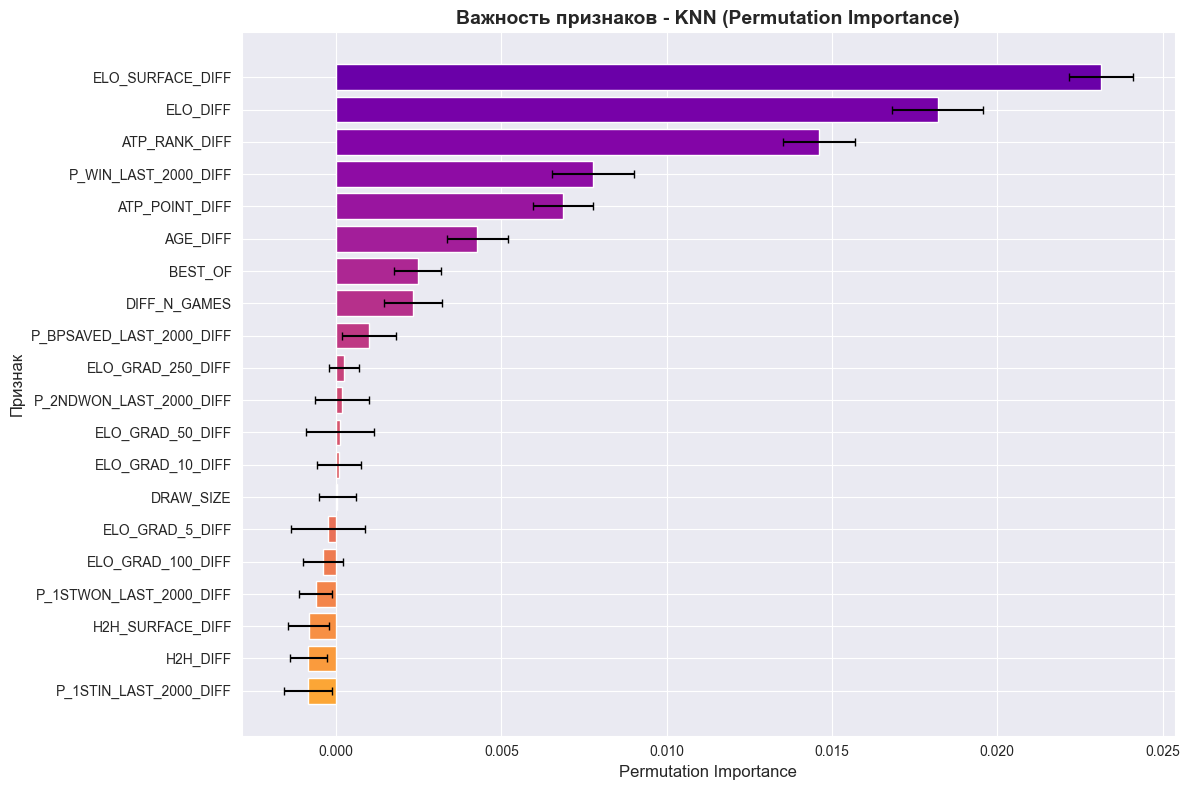

In [25]:
print("="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ - KNN (Permutation Importance)")
print("="*60)

perm_importance = permutation_importance(
    models['KNN'], X_test_scaled, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

knn_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nТоп-15 важных признаков (KNN):")
print(knn_importance.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_knn = knn_importance.head(20)
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_knn)))
plt.barh(top_knn['Feature'], top_knn['Importance'], 
         xerr=top_knn['Std'], color=colors, capsize=3)
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков - KNN (Permutation Importance)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Сравнение важности признаков в разных моделях

In [26]:
print("="*80)
print("СВОДНАЯ ТАБЛИЦА ВАЖНОСТИ ПРИЗНАКОВ (нормализованная)")
print("="*80)

def normalize(arr):
    arr = np.abs(arr)
    return arr / arr.sum()

importance_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': normalize(models['Random Forest'].feature_importances_),
    'Logistic Regression': normalize(np.abs(models['Logistic Regression'].coef_[0])),
    'SVM (Linear)': normalize(np.abs(models['SVM (Linear)'].coef_[0])),
    'KNN (Permutation)': normalize(perm_importance.importances_mean)
})

importance_comparison['Mean'] = importance_comparison[['Random Forest', 'Logistic Regression', 
                                                        'SVM (Linear)', 'KNN (Permutation)']].mean(axis=1)

importance_comparison = importance_comparison.sort_values('Mean', ascending=False)

print("\nТоп-15 признаков по средней важности:")
print(importance_comparison.head(15).to_string(index=False))

СВОДНАЯ ТАБЛИЦА ВАЖНОСТИ ПРИЗНАКОВ (нормализованная)

Топ-15 признаков по средней важности:
                 Feature  Random Forest  Logistic Regression  SVM (Linear)  KNN (Permutation)     Mean
        ELO_SURFACE_DIFF       0.165191             0.220242      0.183495           0.249821 0.204687
                ELO_DIFF       0.168707             0.187374      0.201015           0.196535 0.188408
           ATP_RANK_DIFF       0.103687             0.119086      0.121985           0.157914 0.125668
                AGE_DIFF       0.034395             0.107326      0.103917           0.046151 0.072947
          ATP_POINT_DIFF       0.111268             0.044521      0.024458           0.074045 0.063573
    P_WIN_LAST_2000_DIFF       0.072734             0.022196      0.009276           0.083922 0.047032
 P_1STWON_LAST_2000_DIFF       0.023409             0.055615      0.083058           0.006725 0.042202
            DIFF_N_GAMES       0.041495             0.034409      0.035452          

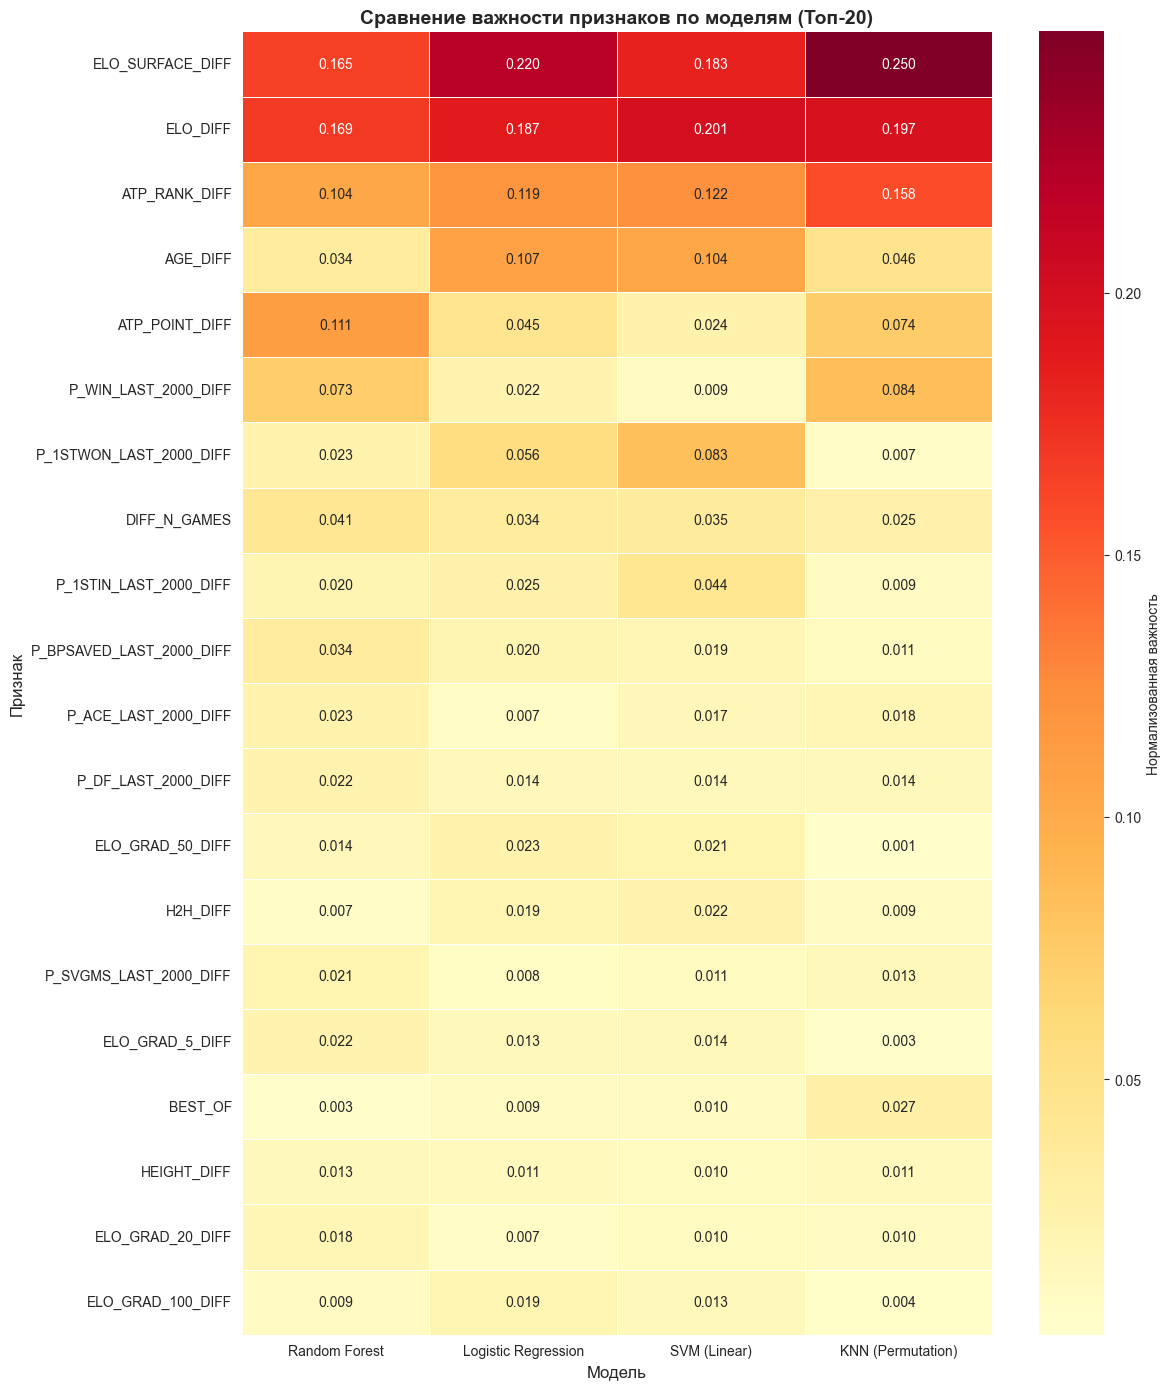

In [27]:
plt.figure(figsize=(12, 14))

top_features = importance_comparison.head(20)

heatmap_data = top_features[['Random Forest', 'Logistic Regression', 'SVM (Linear)', 'KNN (Permutation)']]
heatmap_data.index = top_features['Feature']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Нормализованная важность'})
plt.title('Сравнение важности признаков по моделям (Топ-20)', fontsize=14, fontweight='bold')
plt.xlabel('Модель', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()

## Выводы

In [42]:
print("1. МЕТРИКИ КАЧЕСТВА (отсортировано по ROC-AUC):\n")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]
print(f"\n2. ЛУЧШАЯ МОДЕЛЬ: {best_model['Model']}")

print("\n3. ТОП-5 НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (по средней важности):\n")

for i, row in importance_comparison.head(5).iterrows():
    print(f"    {importance_comparison.head(5).index.get_loc(i)+1}. {row['Feature']} (средняя важность: {row['Mean']:.4f})")

1. МЕТРИКИ КАЧЕСТВА (отсортировано по ROC-AUC):

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.668030   0.669500 0.661766  0.665610 0.732260
       SVM (Linear)  0.667506   0.669148 0.660716  0.664905 0.731864
      Random Forest  0.666090   0.666702 0.662291  0.664489 0.731682
                KNN  0.653193   0.654846 0.645700  0.650241 0.713651

2. ЛУЧШАЯ МОДЕЛЬ: Logistic Regression

3. ТОП-5 НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (по средней важности):

    1. ELO_SURFACE_DIFF (средняя важность: 0.2047)
    2. ELO_DIFF (средняя важность: 0.1884)
    3. ATP_RANK_DIFF (средняя важность: 0.1257)
    4. AGE_DIFF (средняя важность: 0.0729)
    5. ATP_POINT_DIFF (средняя важность: 0.0636)


## Выводы

### Сравнение моделей:

1. **По ROC-AUC (ключевая метрика)**:
   - Все модели показывают схожие результаты (~0.71-0.73)
   - Линейные модели (Логистическая регрессия, SVM Linear) демонстрируют наиболее стабильные результаты

2. **По Accuracy**:
   - Модели достигают точности ~66-67%
   - Это немного лучше случайного угадывания (50%)

3. **По Precision/Recall/F1**:
   - Метрики сбалансированы (Precision ~ Recall), так как датасет сбалансирован

### Важность признаков:

1. **Наиболее важные признаки**:
   - ELO_DIFF - разница в рейтингах ELO
   - ELO_SURFACE_DIFF - разница в рейтингах ELO на конкретном покрытии
   - ATP_POINT_DIFF - разница в ATP очках

